In [21]:
# Import libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# Import libraries for working with dates and times
import datetime as dt

# Import TensorFlow and Keras libraries for building and training neural networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, Reshape, Flatten, GRU
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

# Import scikit-learn library for various metrics and preprocessing tools
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Import matplotlib library for creating plots and charts
import matplotlib.pyplot as plt

# Magic command to display plots inline in the Jupyter Notebook
%matplotlib inline

In [22]:
# Calculate the accuracy of each model
def evaluateModel(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [23]:
# Read in the NEM dataset from a CSV file
df=pd.read_csv("../dataset/cleaned_NEM.csv")
df=df.set_index(pd.DatetimeIndex(df['Date'].values))


# Preprocessing Data

---

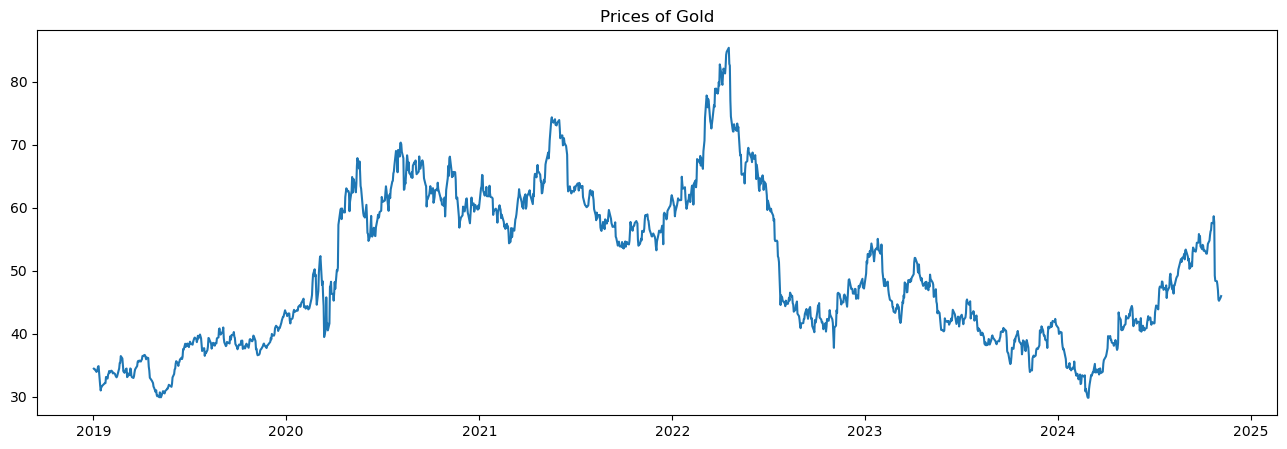

In [24]:

# Format column Date
df.index = pd.to_datetime(df.index,format='%m/%d/%Y')

# Create new Dataframe
df1 = pd.DataFrame(df, columns=['Date', 'Close'])
df1.drop('Date', axis = 1, inplace = True)

# Plot the 'price' column of the 'df' DataFrame
plt.figure(figsize=(16,5))
plt.plot(df1['Close'])
plt.title('Prices of Gold')
plt.show()

# Split dataset (7-2-1)

---



In [25]:
# Create a MinMaxScaler object with a specified range
data = df1.values
sc = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler to the data and transform the data
sc_train = sc.fit_transform(data)

# Split the data
train_size = int(0.7 * len(sc_train))
test_size = int(0.2 * len(sc_train))
val_size = len(sc_train) - train_size - test_size

train_data = sc_train[:train_size]
test_data = sc_train[train_size:train_size+test_size]
val_data = sc_train[train_size+test_size:]

In [26]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [27]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [28]:
# Build the model
model = Sequential()

# Add a GRU layer with 50 units, input shape of (x_train.shape[1], 1), and return_sequences set to True
model.add(GRU(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))

# Add another GRU layer with 50 units and return_sequences set to True
model.add(GRU(50, return_sequences=True))

# Add a final GRU layer with 50 units
model.add(GRU(50))

# Add a dense layer with 1 unit
model.add(Dense(1))

# Compile the model with the 'mean_absolute_error' loss function and the 'adam' optimizer
model.compile(loss='mean_absolute_error', optimizer='adam')

# Set the filename to use for saving the model with the correct '.keras' extension
save_model = 'save_model_7_2_1.keras'

# Create a ModelCheckpoint object to save the best model during training
best_model = ModelCheckpoint(
    filepath=save_model,
    monitor='loss',
    verbose=2,
    save_best_only=True,
    mode='auto'
)

# Train the model using the 'fit' method
model.fit(
    x_train,
    y_train,
    epochs=80,
    batch_size=50,
    verbose=2,
    callbacks=[best_model]
)

Epoch 1/80


c:\Users\yashi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: loss improved from inf to 0.15040, saving model to save_model_7_2_1.keras
21/21 - 4s - 202ms/step - loss: 0.1504
Epoch 2/80

Epoch 2: loss improved from 0.15040 to 0.03878, saving model to save_model_7_2_1.keras
21/21 - 0s - 8ms/step - loss: 0.0388
Epoch 3/80

Epoch 3: loss improved from 0.03878 to 0.02643, saving model to save_model_7_2_1.keras
21/21 - 0s - 7ms/step - loss: 0.0264
Epoch 4/80

Epoch 4: loss did not improve from 0.02643
21/21 - 0s - 5ms/step - loss: 0.0280
Epoch 5/80

Epoch 5: loss improved from 0.02643 to 0.02604, saving model to save_model_7_2_1.keras
21/21 - 0s - 7ms/step - loss: 0.0260
Epoch 6/80

Epoch 6: loss improved from 0.02604 to 0.02501, saving model to save_model_7_2_1.keras
21/21 - 0s - 8ms/step - loss: 0.0250
Epoch 7/80

Epoch 7: loss did not improve from 0.02501
21/21 - 0s - 6ms/step - loss: 0.0259
Epoch 8/80

Epoch 8: loss improved from 0.02501 to 0.02415, saving model to save_model_7_2_1.keras
21/21 - 0s - 8ms/step - loss: 0.0241
Epoch 9/80

E

In [29]:
# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model_7_2_1.keras')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [30]:
# Preprocess the test data
test = df1[len(train_data)-5:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(5, test.shape[0]):
    x_test.append(sc_test[i-5:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [31]:
# Preprocess the validate data
val = df1[train_size+test_size-5:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(5, val.shape[0]):
    x_val.append(sc_val[i-5:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [32]:
# Dự báo dữ liệu test, val
train_predict=model.predict(x_train)
y_pred=model.predict(x_test)
y_pred_val=model.predict(x_val)

# Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=sc.inverse_transform(train_predict)
y_pred=sc.inverse_transform(y_pred)
y_pred_val=sc.inverse_transform(y_pred_val)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [33]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[len(sc_train) - 5:].reshape(1, -1)

# Print the shape of the input array
print(x_input.shape)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Print the temp_input variable
print(temp_input)

(1, 5)
[0.3074153846309132, 0.2804175432724767, 0.2771777967299105, 0.2861770771827227, 0.29049676203765484]


In [34]:
# Initialize variables
lst_output = []
n_steps = 5
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 5):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, -1))
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.30109521746635437], [0.3106839656829834], [0.32041364908218384], [0.33024224638938904], [0.34016385674476624], [0.35023707151412964], [0.3604467213153839], [0.3707960844039917], [0.38128596544265747], [0.3919175863265991], [0.40269264578819275], [0.4136124849319458], [0.42467835545539856], [0.435891717672348], [0.4472534656524658], [0.4587646424770355], [0.47042617201805115], [0.48223868012428284], [0.49420279264450073], [0.5063187479972839], [0.5185866355895996], [0.5310063362121582], [0.5435774922370911], [0.5562994480133057], [0.5691714286804199], [0.582192063331604], [0.5953595638275146], [0.6086720824241638], [0.6221272349357605], [0.6357222199440002]]


In [39]:
# Convert the 'Date' column in the dataframe to a list of strings
datelist_train = df['Date'].astype(str).tolist()

# Parse the date strings using strptime(), using the correct format string '%m/%d/%Y'
datelist_train = [dt.datetime.strptime(date, '%m/%d/%Y').date() for date in datelist_train]

# Generate a list of future dates, starting from the last date in the training data and going for 30 days
datelist_future = pd.date_range(datelist_train[-1] + dt.timedelta(days=1), periods=30, freq='1d').tolist()

In [40]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Print the inverse transformed list of predictions
print(y_pred_future)

[[46.58885016]
 [47.12160099]
 [47.66218217]
 [48.20825901]
 [48.75950366]
 [49.31917145]
 [49.88641957]
 [50.46143015]
 [51.04424792]
 [51.63494075]
 [52.23360303]
 [52.84030926]
 [53.455129  ]
 [54.07814338]
 [54.70940207]
 [55.34896303]
 [55.99687758]
 [56.6531805 ]
 [57.31790656]
 [57.99106901]
 [58.67267282]
 [59.36271135]
 [60.06116475]
 [60.76799658]
 [61.4831638 ]
 [62.20659023]
 [62.93817652]
 [63.67782002]
 [64.42538827]
 [65.1807256 ]]


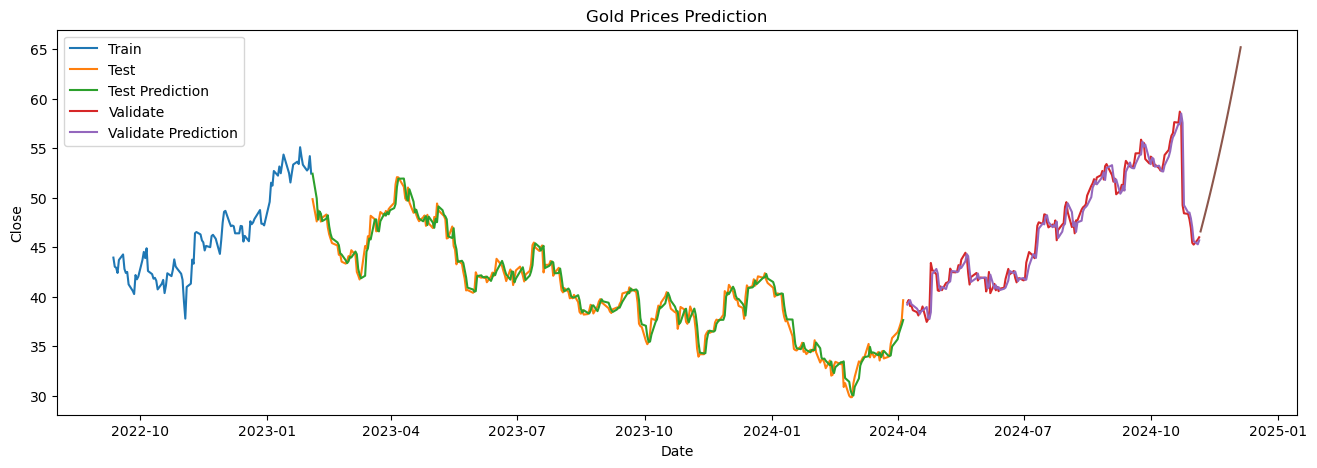

In [41]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['close']).set_index(pd.Series(datelist_future))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.plot(train_data.index[train_size-100:], train_data.Close[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Gold Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [42]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  0.670803310172609
MAPE:  1.6699600358653768
RMSE:  0.8844462198418571

** Validate **
MAE:  0.7245034913795925
MAPE:  1.5499585822519786
RMSE:  1.1359465820615653


# Split dataset (6-3-1)

---



In [43]:
# Split the data
train_size = int(0.6 * len(sc_train))
test_size = int(0.3 * len(sc_train))
val_size = len(sc_train) - train_size - test_size

train_data = sc_train[:train_size]
test_data = sc_train[train_size:train_size+test_size]
val_data = sc_train[train_size+test_size:]

In [44]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [45]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [46]:
# Set the filename to use for saving the model with the correct .keras extension
save_model = 'save_model_6_3_1.keras'

# Create a ModelCheckpoint object to save the model during training
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

# Train the model using the 'fit' method
model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])


Epoch 1/80



Epoch 1: loss improved from inf to 0.01683, saving model to save_model_6_3_1.keras
18/18 - 0s - 7ms/step - loss: 0.0168
Epoch 2/80

Epoch 2: loss improved from 0.01683 to 0.01544, saving model to save_model_6_3_1.keras
18/18 - 0s - 7ms/step - loss: 0.0154
Epoch 3/80

Epoch 3: loss did not improve from 0.01544
18/18 - 0s - 5ms/step - loss: 0.0169
Epoch 4/80

Epoch 4: loss did not improve from 0.01544
18/18 - 0s - 6ms/step - loss: 0.0162
Epoch 5/80

Epoch 5: loss did not improve from 0.01544
18/18 - 0s - 5ms/step - loss: 0.0162
Epoch 6/80

Epoch 6: loss did not improve from 0.01544
18/18 - 0s - 5ms/step - loss: 0.0179
Epoch 7/80

Epoch 7: loss did not improve from 0.01544
18/18 - 0s - 5ms/step - loss: 0.0183
Epoch 8/80

Epoch 8: loss did not improve from 0.01544
18/18 - 0s - 5ms/step - loss: 0.0184
Epoch 9/80

Epoch 9: loss did not improve from 0.01544
18/18 - 0s - 5ms/step - loss: 0.0157
Epoch 10/80

Epoch 10: loss did not improve from 0.01544
18/18 - 0s - 5ms/step - loss: 0.0176
Epoch

In [47]:
# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model_6_3_1.keras')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [48]:
# Preprocess the test data
test = df1[len(train_data)-5:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(5, test.shape[0]):
    x_test.append(sc_test[i-5:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [49]:
# Preprocess the validate data
val = df1[train_size+test_size-5:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(5, val.shape[0]):
    x_val.append(sc_val[i-5:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [50]:
# Dự báo dữ liệu test, val
train_predict=model.predict(x_train)
y_pred=model.predict(x_test)
y_pred_val=model.predict(x_val)

# Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=sc.inverse_transform(train_predict)
y_pred=sc.inverse_transform(y_pred)
y_pred_val=sc.inverse_transform(y_pred_val)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [51]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[len(sc_train) - 5:].reshape(1, -1)

# Print the shape of the input array
print(x_input.shape)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Print the temp_input variable
print(temp_input)

(1, 5)
[0.3074153846309132, 0.2804175432724767, 0.2771777967299105, 0.2861770771827227, 0.29049676203765484]


In [52]:
# Initialize variables
lst_output = []
n_steps = 5
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 5):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, -1))
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.2891906499862671], [0.2871975898742676], [0.28520700335502625], [0.28345757722854614], [0.28181192278862], [0.28016749024391174], [0.27850764989852905], [0.27683374285697937], [0.2751511037349701], [0.27346184849739075], [0.27176597714424133], [0.2700631320476532], [0.2683532238006592], [0.26663604378700256], [0.2649115025997162], [0.2631795406341553], [0.2614400386810303], [0.2596929371356964], [0.2579382061958313], [0.2561756670475006], [0.2544052302837372], [0.25262686610221863], [0.2508404552936554], [0.24904587864875793], [0.24724309146404266], [0.24543192982673645], [0.2436123639345169], [0.24178428947925568], [0.23994757235050201], [0.23810212314128876]]


In [53]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Print the inverse transformed list of predictions
print(y_pred_future)

[[45.92743242]
 [45.816698  ]
 [45.70610102]
 [45.60890291]
 [45.51747035]
 [45.42610568]
 [45.33388496]
 [45.24088269]
 [45.14739526]
 [45.05354025]
 [44.95931764]
 [44.86470757]
 [44.76970507]
 [44.67429855]
 [44.57848305]
 [44.48225525]
 [44.38560852]
 [44.28853956]
 [44.19104672]
 [44.09312005]
 [43.99475458]
 [43.89594867]
 [43.79669569]
 [43.69698902]
 [43.59682617]
 [43.49619803]
 [43.39510296]
 [43.29353514]
 [43.19148714]
 [43.08895399]]


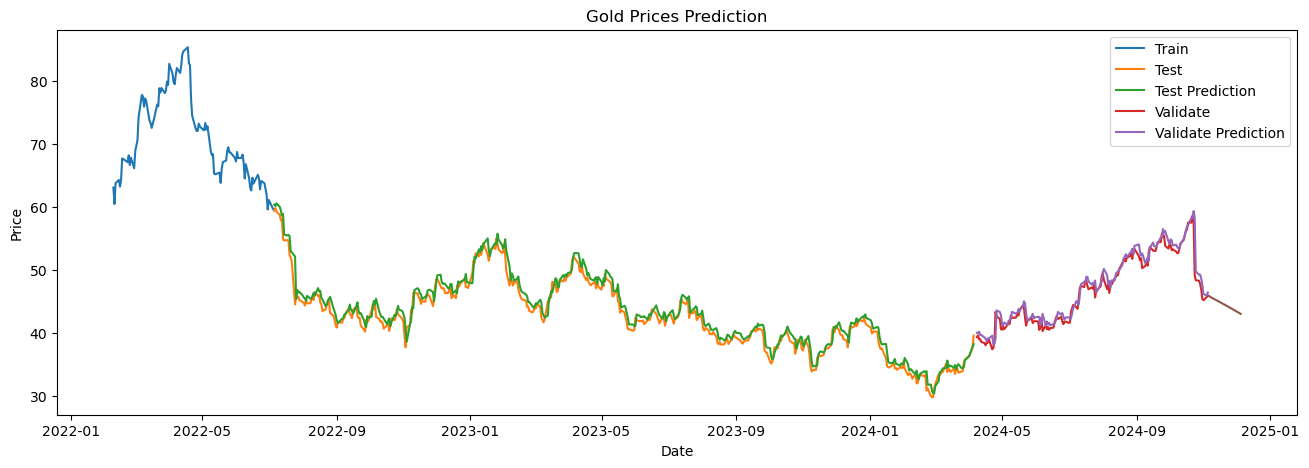

In [54]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.plot(train_data.index[train_size-100:], train_data.Close[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Gold Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [55]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  0.9600249612080034
MAPE:  2.2754497396472404
RMSE:  1.2218670908615117

** Validate **
MAE:  0.8887799237853674
MAPE:  1.9341099160314974
RMSE:  1.306276507403194


# Split dataset (5-3-2)

---



In [56]:
# Split the data
train_size = int(0.5 * len(sc_train))
test_size = int(0.3 * len(sc_train))
val_size = len(sc_train) - train_size - test_size

train_data = sc_train[:train_size]
test_data = sc_train[train_size:train_size+test_size]
val_data = sc_train[train_size+test_size:]

In [57]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [58]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [59]:
# Build the model
model = Sequential()

# Add an GRU layer with 50 units, input shape of (x_train.shape[1], 1), and return_sequences set to True
model.add(GRU(50,return_sequences=True,input_shape=(x_train.shape[1],1)))

# Add an GRU layer with 50 units
model.add(GRU(50,return_sequences=True))

# Add an GRU layer with 50 units
model.add(GRU(50))

# Add a dense layer with 1 unit
model.add(Dense(1))

# Compile the model with the 'mean_absolute_error' loss function and the 'adam' optimizer
model.compile(loss='mean_absolute_error', optimizer='adam')
# Set the filename to use for saving the model
save_model = 'save_model_6_3_1.keras'

# Create a ModelCheckpoint object to save the model during training
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

# Train the model using the 'fit' method
model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/80


c:\Users\yashi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: loss improved from inf to 0.15496, saving model to save_model_6_3_1.keras
15/15 - 4s - 251ms/step - loss: 0.1550
Epoch 2/80

Epoch 2: loss improved from 0.15496 to 0.05810, saving model to save_model_6_3_1.keras
15/15 - 0s - 8ms/step - loss: 0.0581
Epoch 3/80

Epoch 3: loss improved from 0.05810 to 0.02741, saving model to save_model_6_3_1.keras
15/15 - 0s - 12ms/step - loss: 0.0274
Epoch 4/80

Epoch 4: loss improved from 0.02741 to 0.02430, saving model to save_model_6_3_1.keras
15/15 - 0s - 13ms/step - loss: 0.0243
Epoch 5/80

Epoch 5: loss improved from 0.02430 to 0.02410, saving model to save_model_6_3_1.keras
15/15 - 0s - 12ms/step - loss: 0.0241
Epoch 6/80

Epoch 6: loss did not improve from 0.02410
15/15 - 0s - 7ms/step - loss: 0.0243
Epoch 7/80

Epoch 7: loss improved from 0.02410 to 0.02375, saving model to save_model_6_3_1.keras
15/15 - 0s - 8ms/step - loss: 0.0238
Epoch 8/80

Epoch 8: loss improved from 0.02375 to 0.02325, saving model to save_model_6_3_1.keras
15/

In [60]:
# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model_6_3_1.keras')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [61]:
# Preprocess the test data
test = df1[len(train_data)-5:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(5, test.shape[0]):
    x_test.append(sc_test[i-5:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [62]:
# Preprocess the validate data
val = df1[train_size+test_size-5:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(5, val.shape[0]):
    x_val.append(sc_val[i-5:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [63]:
# Dự báo dữ liệu test, val
train_predict=model.predict(x_train)
y_pred=model.predict(x_test)
y_pred_val=model.predict(x_val)

# Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=sc.inverse_transform(train_predict)
y_pred=sc.inverse_transform(y_pred)
y_pred_val=sc.inverse_transform(y_pred_val)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [64]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[len(sc_train) - 5:].reshape(1, -1)

# Print the shape of the input array
print(x_input.shape)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Print the temp_input variable
print(temp_input)

(1, 5)
[0.3074153846309132, 0.2804175432724767, 0.2771777967299105, 0.2861770771827227, 0.29049676203765484]


In [65]:
# Initialize variables
lst_output = []
n_steps = 5
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 5):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, -1))
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.28988146781921387], [0.2895261347293854], [0.28928741812705994], [0.28923919796943665], [0.28922516107559204], [0.28919103741645813], [0.28915202617645264], [0.28911149501800537], [0.2890723645687103], [0.28903433680534363], [0.28899699449539185], [0.2889603078365326], [0.2889242172241211], [0.28888875246047974], [0.28885385394096375], [0.2888196110725403], [0.2887859344482422], [0.28875279426574707], [0.2887202501296997], [0.2886882424354553], [0.2886568307876587], [0.28862592577934265], [0.2885955572128296], [0.2885657250881195], [0.2885363698005676], [0.28850749135017395], [0.28847911953926086], [0.28845128417015076], [0.2884238660335541], [0.2883969843387604]]


In [66]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Print the inverse transformed list of predictions
print(y_pred_future)

[[45.96581425]
 [45.94607195]
 [45.93280886]
 [45.93012974]
 [45.92934985]
 [45.92745394]
 [45.92528648]
 [45.92303457]
 [45.92086048]
 [45.91874766]
 [45.91667292]
 [45.91463461]
 [45.91262941]
 [45.91065899]
 [45.90872003]
 [45.9068175 ]
 [45.90494642]
 [45.90310515]
 [45.901297  ]
 [45.89951866]
 [45.89777342]
 [45.89605634]
 [45.89436906]
 [45.89271159]
 [45.89108061]
 [45.88947613]
 [45.88789979]
 [45.88635325]
 [45.8848299 ]
 [45.88333636]]


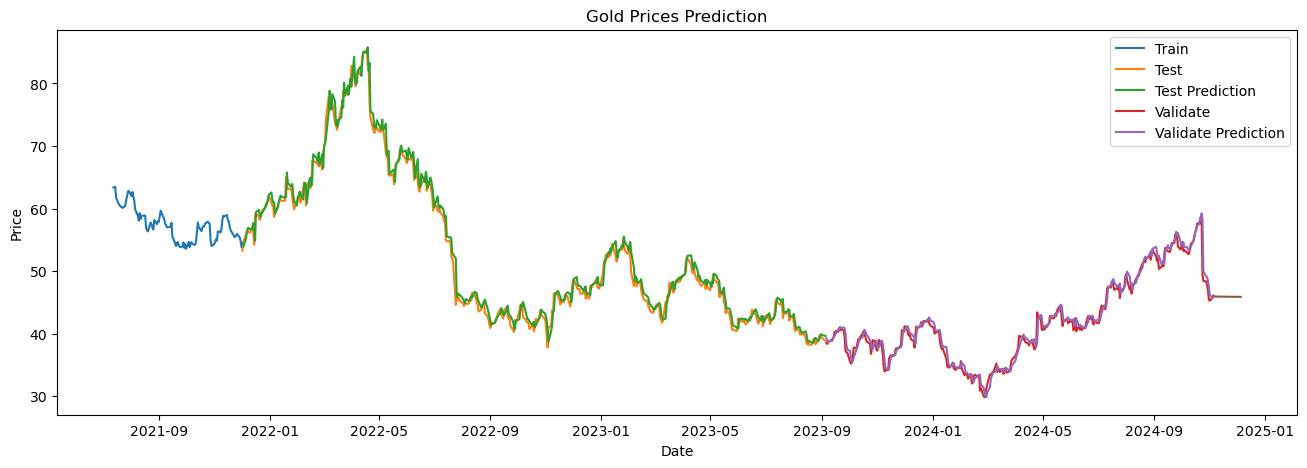

In [67]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.plot(train_data.index[train_size-100:], train_data.Close[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Gold Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [68]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  1.0082531452405974
MAPE:  1.9205687541997016
RMSE:  1.3455971082277853

** Validate **
MAE:  0.7414932899470669
MAPE:  1.8113061348277646
RMSE:  1.085163785019598


# Evaluating model

---

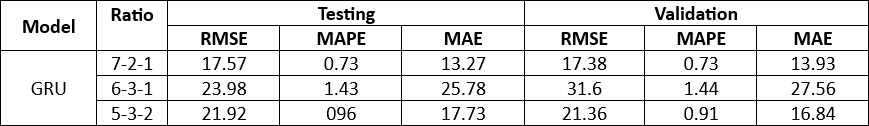
